In [489]:
# Code Utilities

## Imports
import numpy as np
import control
import matplotlib.pyplot as plt
import typing
import pandas as pd
import copy
from scipy.linalg import expm
from scipy import signal

## Constants
SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10
SAMPLES_PER_PERIOD = SR_F_HZ // SQ_WAVE_F_HZ


## Functions
SampledData = typing.Dict[typing.Literal['Time', 'ADC', 'DAC'], 
                          np.ndarray] 

def extract_data(df: pd.DataFrame, periods:float=1, samples_offset:int=0) -> SampledData:
    nsamples = int(periods * SAMPLES_PER_PERIOD)
    return {
        'Time':np.arange(nsamples) * 1 / SR_F_HZ,
        'ADC': np.array(df['ADC'][samples_offset:samples_offset+nsamples]),
        'DAC': np.array(df['DAC'][samples_offset:samples_offset+nsamples]) 
    }

def normalize(d: SampledData):
    floor = min(d['DAC'])
    scaling = max(d['DAC']) - floor
    scaled_data = {**d}
    for k in 'ADC', 'DAC':
        scaled_data[k] = (scaled_data[k] - floor) / scaling
    return scaled_data

def calc_risetime(data: np.ndarray, timearr: np.ndarray):
    # Calculamos los límites para el risetime.
    v10 = (data.max() - data.min())*.1 + data.min()
    v90 = (data.max() - data.min())*.9 + data.min()

    # Buscamos los instantes en los que ocurren.
    t10_i = np.argmin(np.abs((data - v10))) 
    t90_i = np.argmin(np.abs((data - v90))) 
    return timearr[t90_i] - timearr[t10_i] , (t10_i, t90_i) 

def plot_risetime(d: SampledData, title) -> float:
    tr, (t10_i, t90_i) = calc_risetime(d['ADC'], d['Time'])
    plt.figure(figsize=(20, 5))
    plt.plot(d['Time'], d['ADC'], '-o')
    plt.axvline(d['Time'][t10_i], color='red', linestyle='--')
    plt.axvline(d['Time'][t90_i], color='red', linestyle='--')
    plt.axvspan(d['Time'][t10_i], d['Time'][t90_i], facecolor='blue', alpha=0.2)
    plt.plot(d['Time'][t10_i], d['ADC'][t10_i], 'o', markersize=20)
    plt.plot(d['Time'][t90_i], d['ADC'][t90_i], 'o', markersize=20)
    plt.title(f'{title} - Rise Time: <{tr * 1000:.2f}> ms')
    plt.ylabel('Magnitude')
    plt.xlabel('Time [Sec]')
    plt.grid()
    return tr



# Relevamiento del tiempo de Subida

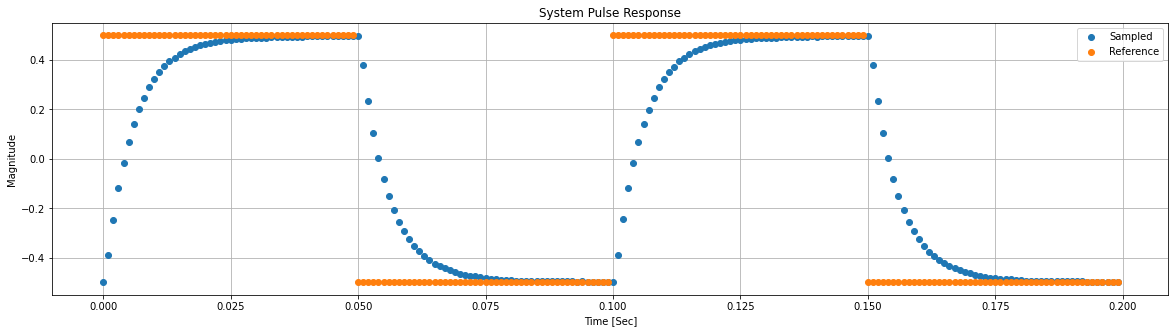

In [271]:
# Cargamos los datos.
data = pd.read_csv('csvs/step_resp.csv')
sd = extract_data(data, periods=2)

# Ploteamos dos ciclos.
plt.figure(figsize=(20, 5))
plt.plot(sd['Time'], sd['ADC'], 'o', label='Sampled')
plt.plot(sd['Time'], sd['DAC'], 'o', label='Reference')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()
plt.grid()

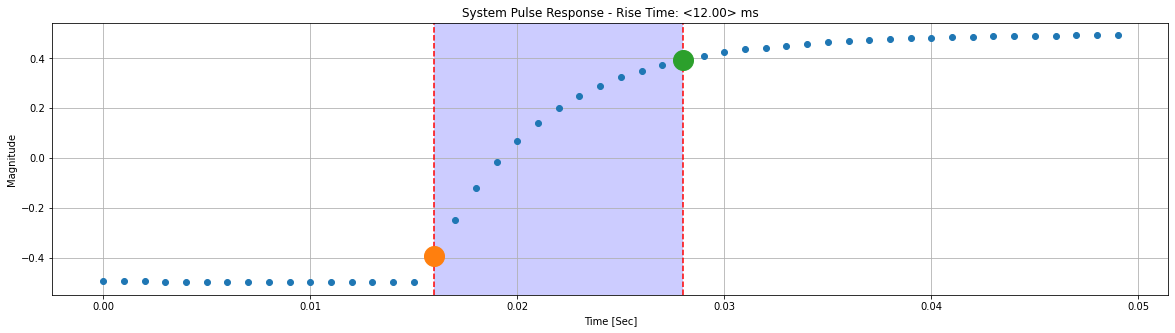

In [277]:
sd2 = extract_data(data, 1/2, samples_offset=185)
rs, (t1, t2) = calc_risetime(sd2['ADC'], sd2['Time'])

# Graficamos.
plt.figure(figsize=(20, 5))
plt.plot(sd2['Time'], sd2['ADC'], 'o')
plt.axvline(sd2['Time'][t1], color='red', linestyle='--')
plt.axvline(sd2['Time'][t2], color='red', linestyle='--')
plt.axvspan(sd2['Time'][t1], sd2['Time'][t2], facecolor='blue', alpha=0.2)
plt.plot(sd2['Time'][t1], sd2['ADC'][t1], 'o', markersize=20)
plt.plot(sd2['Time'][t2], sd2['ADC'][t2], 'o', markersize=20)
plt.title(f'System Pulse Response - Rise Time: <{rs * 1000:.2f}> ms')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

# Identificación de Coeficientes (LS)
* Se utilizó el algoritmo de LS en la EDU-CIAA
* El tiempo de sampleo y actualizacion del DAC se fijó en 10ms
* El período de actualización del algoritmo también se fijó en 10ms
* Se eligió un tamaño de filtro orden 2:
  * 3 Coeficientes que multiplican a la entrada: $b_o$, $b_1$ y $b_2$
  * 2 Coeficientes que multiplican a las salidas: $a_1$ y $a_2$
  * $a_o$ se toma como 1 para la constucción del modelo
* Señal de entrada: PRBS:
  * Generada a partir de la función `rand()` de la librería estandar de C
  * El valor de la señal se actualiza cada 10ms
  * Los valores del DAC varían entre 0 y 3v3: su rango completo

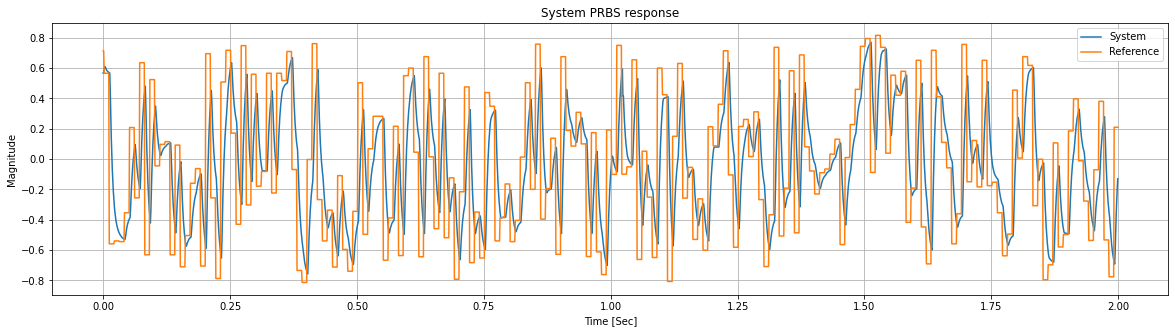

In [267]:
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000

# Datos capturados de la respuesta del sistema a la señal PRBS.
data2 = pd.read_csv('csvs/ls_output_data.csv')
plt.figure(figsize=(20, 5))
plt.plot(data2[:2000]['Time'], data2[:2000]['ADC'], label='System')
plt.plot(data2[:2000]['Time'], data2[:2000]['DAC'], label='Reference')
plt.grid()
plt.title('System PRBS response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()


Polo Teórico S 0: 362.997Hz
Polo Teórico S 1: 34.891Hz
Polo Teórico Z 0: 401.571Hz
Polo Teórico Z 1: 51.102Hz
Polo Empírico 0: 418.565Hz
Polo Empírico 1: -209.462Hz


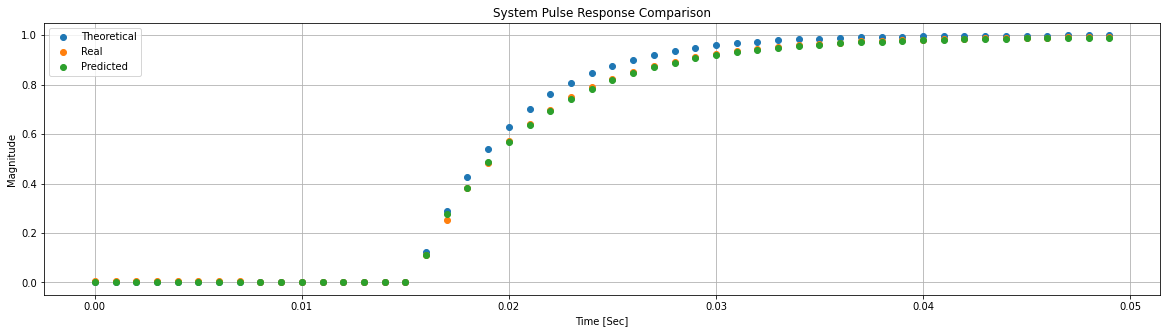

In [361]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt
from scipy import signal

## Sistema Teórico

# Componentes
r_1, c_1, r_2, c_2 = 10e3, 100e-9, 10e3, 200e-9

# Transferencia teórica
s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)

# Polos
for i, pole_hz in enumerate(poles(hs_1) / (2*np.pi)):
    print(f'Polo Teórico S {i}: {float(-pole_hz.real):.3f}Hz')

# Transferencia teórica discretizada
hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
for i, pole_hz in enumerate((poles(hz_1) * SR_F_HZ / 2)):
    print(f'Polo Teórico Z {i}: {float(pole_hz.real):.3f}Hz')


# Transferencia reconstruida por LS del modelo
knum = [0.00098912, 0.110023150, 0.11815254]
den = [1, -0.41820698, -0.35069335]
rls_tf = tf(np.array(knum), np.array(den), dt=1/SR_F_HZ)
ss_rls = tf2ss(rls_tf) 
for i, pole_hz in enumerate(poles(rls_tf)* SR_F_HZ / 2):
    print(f'Polo Empírico {i}: {float(pole_hz.real):.3f}Hz')

sd3 = extract_data(data, periods=1/2, samples_offset=185)
sd3n = normalize(sd3)

# Comparamos la respuesta al escalón con las anteriores
t, hz_out = forced_response(hz_1, sd3n['Time'], sd3n['DAC'])
t2, s = forced_response(rls_tf, sd3n['Time'], sd3n['DAC'])
plt.figure(figsize=(20, 5))
plt.plot(t, hz_out[:len(sd3n['Time'])], 'o', label='Theoretical')
plt.plot(sd3n['Time'], sd3n['ADC'], 'o', label='Real')
plt.plot(t2, s, 'o', label='Predicted')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

## Selección del Tiempo de Muestreo 
Para la selección del tiempo de muestreo se realizaron primero dos mediciones
de performance en el código. Dichas mediciones se realizaron utilizando el 
contador de ciclos de clock de la EDU-CIAA a fines de maximizar la precisión
de las mediciones. Para visualizar los resultados sin realentizar el loop 
principal, se ha utilizado el debugger para frenar la ejecución del programa
inmediatamente después de la medición temporal, tomando nota de la diferencia
del valor del contador respecto al inicio del lazo.

La primera medición se realizó en el loop principal del programa `pid_app` sin
transferir datos por puerto serie. La segunda medicion se realizó en el mismo
programa, incluyendo la transferencia de datos.

In [283]:
loop_period = 1 / SR_F_HZ
loop_cycles = 20400
non_uart_loop_cycles = 2820  # This includes ADC + DAC + PID Compute
with_uart_loop_cycles = 11474

def cycles_to_ms(cycles):
    return (cycles * loop_period) * 1000 / loop_cycles

print(f'Without UART: {cycles_to_ms(non_uart_loop_cycles)} ms')
print(f'With UART: {cycles_to_ms(with_uart_loop_cycles)} ms')

min_sampling_time = cycles_to_ms(with_uart_loop_cycles)
print(f'Min sampling time with UART: {min_sampling_time} ms')


target_samples_per_trise = 6  # Between 4 and 20 is Ok.

trise_s = 13e-3 
target_trise = trise_s * 0.7
th_min = target_trise / target_samples_per_trise
print(f'Max sampling time: {th_min * 1000}ms')


Without UART: 0.13823529411764707 ms
With UART: 0.5624509803921569 ms
Min sampling time with UART: 0.5624509803921569 ms
Max sampling time: 1.5166666666666664ms


Para poder capturar los resultados de salida, se considera el tiempo del lazo
de sistema _con_ la UART reportando datos. Esto degrada considerablemente el 
tiempo del lazo principal, pero dado que el alumno no cuenta con un osciloscopio
para medir la respuesta, no utilizar la UART para reporte de datos no es opción.

Así y todo, sampleando a 1ms es posible capturar más de 6 muestras de las
transiciones de la señal a lazo cerrado, y dejando libre aproximadamente el 
50% de la ventana de computo que tiene el programa entre dos instantes de 
actuacion consecutivos (1ms).


## Control PID 
Como parte del control PID, se implementa el algoritmo visto en clase, 
con los 3 terminos (proporcional, integrativo y derivativo) incluyendo 
características como anti-windup, zonas muertas, filtro pasabajos en el término
derivativo, entre otros.

Primero, utilizando los coeficientes adquiridos mediante LS, se simula la planta
en conjunto con una implementación en Python del PID a ser utilizado en C. Se
busca con eso ajustar los parámetros a fines de controlar la respuesta al escalón 
del sistema tal que cumpla con los requerimientos de rise-time y estado 
estacionario propuestos en el trabajo. Luego, se utilizan dichos coeficientes
como punto de partida para el ajuste de parámetros en el microcontrolador. 
Finalmente, se capturan las muestras del PID corriendo en el hardware en tiempo
real correspondientes a las siguientes señales:
- Señal de referencia (tren de pulsos simétrico a 10Hz con amplitud 0.5)
- Señal medida por el ADC a la salida de la planta
- Señal de error del controlador PID
- Señal de salida del PID (entrada de la planta)
A partir de ellas se muestran gráficos en las últimas céldas, mostrando la
mejora en la respuesta del sistema.

### Aclaraciones
A efectos de simplificar la interpretación de los cálculos, tanto en controlador
del MCU como los datos mostrados se han trabajado en el rango de -1 a 1. En
en el microcontrolador esto se lee/escribe en el el ADC/DAC como número digital
de 10bits, que termina traduciendose en 3v3 para el máximo número (1023) y 0
para el menor.
En base a esto, la señal de referencia cuadrada se ha elegido con amplitud 0.5
para permitir que el controlador pueda, durante el transitorio, entregar mayor
voltaje que la señal de referencia. De lo contrario, se imposibilitaría mejorar
el rise time.



In [288]:
from dataclasses import dataclass, field


@dataclass
class PIDController:
    Kp: float
    Ki: float
    Kd: float
    T: float        # Discrete period
    limMax: float
    limMin: float
    limMaxInt: float
    limMinInt: float
    tau: float
    deadZone: float
    bypassPid: bool = False
    out: float = field(init=False, default=0)
    prevError: float = field(init=False, default=0)
    prevMeasurement: float = field(init=False, default=0)
    differentiator: float = field(init=False, default=0)
    integrator: float = field(init=False, default=0)

    def compute(self, setpoint, measurement) -> float:
        if self.bypassPid:
            return setpoint
        
        error = setpoint - measurement
        
        if abs(error) < self.deadZone:
            return self.out
        
        proportional = self.Kp * error
        
        self.integrator += 0.5 * self.Ki * self.T * (error + self.prevError)
        
        if self.integrator > self.limMaxInt:
            self.integrator = self.limMaxInt
        elif self.integrator < self.limMinInt:
            self.integrator = self.limMinInt
        
        self.differentiator = -(2.0 * self.Kd * (measurement - self.prevMeasurement)
                                + (2.0 * self.tau - self.T) * self.differentiator) / (2.0 * self.tau + self.T)
        
        self.out = proportional + self.integrator + self.differentiator
        
        if self.out > self.limMax:
            self.out = self.limMax
        elif self.out < self.limMin:
            self.out = self.limMin
        
        self.prevError = error
        self.prevMeasurement = measurement

        return self.out


def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_controller: PIDController) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.zeros(len(input) + n_inicial)
    
    for k in range(n_inicial, len(r)):

      for m in range(0, len(b)):
        y[k] = y[k] + (b[m] * u[k-m])
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]
      u[k] = pid_controller.compute(r[k], y[k-1])

    return y[n_inicial-1:], u


In [294]:
import numpy as np
import control as cnt
from scipy.linalg import expm
import matplotlib.pyplot as plt
SR_F_HZ = 1000

h = 1/SR_F_HZ
numz = [0.00098912, 0.110023150, 0.11815254]
denz = [1, -0.41820698, -0.35069335]
hz = cnt.tf(numz, denz, dt=h)


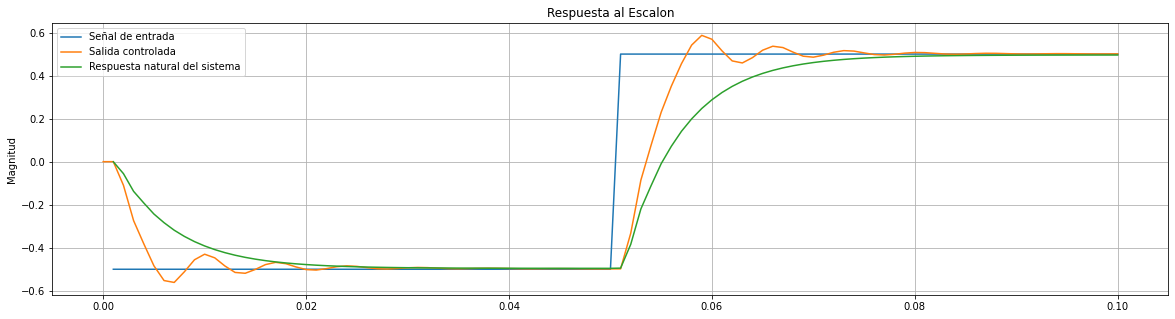

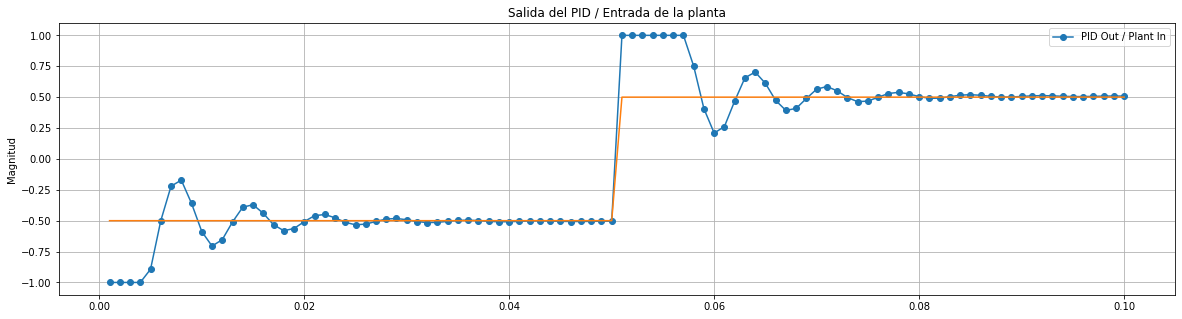

In [322]:
t = np.linspace(h, h * 100, 100)
r = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None) - 0.5

pid = PIDController(
    Kp=4, Ki=250.0, Kd=0.0, T = 1.0 / SR_F_HZ,
    limMin = -1,
    limMax = 1,
    limMinInt = -10.0,
    deadZone = 0.0,
    tau = 1.0 / SR_F_HZ,
    bypassPid=False,
    limMaxInt = 10.0)

y_hz_pid, u = pid_controller_response(numz, denz, r, pid)
t_hz_open, y_hz_open = cnt.forced_response(hz, t, r)

plt.figure(figsize=(20, 5))
p_1 = plt.plot(t, r)
p_2 = plt.plot(np.arange(len(y_hz_pid)) * 1/ SR_F_HZ , y_hz_pid)
p_3 = plt.plot(t_hz_open, y_hz_open)
plt.ylabel('Magnitud')
plt.title('Respuesta al Escalon')
plt.grid()
plt.legend((p_1[0], p_2[0], p_3[0]), ('Señal de entrada', 'Salida controlada', 'Respuesta natural del sistema'));
plt.show()


plt.figure(figsize=(20, 5))
plt.ylabel('Magnitud')
plt.grid()
plt.title('Salida del PID / Entrada de la planta')
plt.plot(t, u[2:], '-o', label='PID Out / Plant In')
plt.legend()
plt.plot(t, r, label='Señal de referencia')
plt.show()



In [310]:
def calculater_rise_time(sig, t=None, ref=1):
    t = t if t is not None else list(range(len(sig)))
    ths = [np.argmax(sig >= th * ref) for th in (.1, .9)]
    return t[ths[1]] - t[ths[0]]


r1 = calculater_rise_time(y_hz_open)
r2 = calculater_rise_time(y_hz_pid)
overshoot = (max(y_hz_pid)/max(r) - 1) * 100
print(f'Overshoot: {overshoot}%')
print(f'Rise Time Improvement (simulation) {(1 - r2/r1)*100}%')

Overshoot: 10.148035721995385%
Rise Time Improvement (simulation) 0.0%


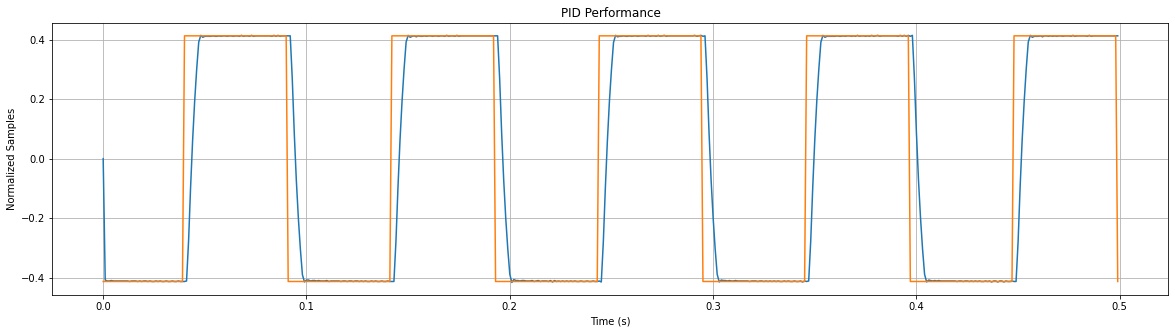

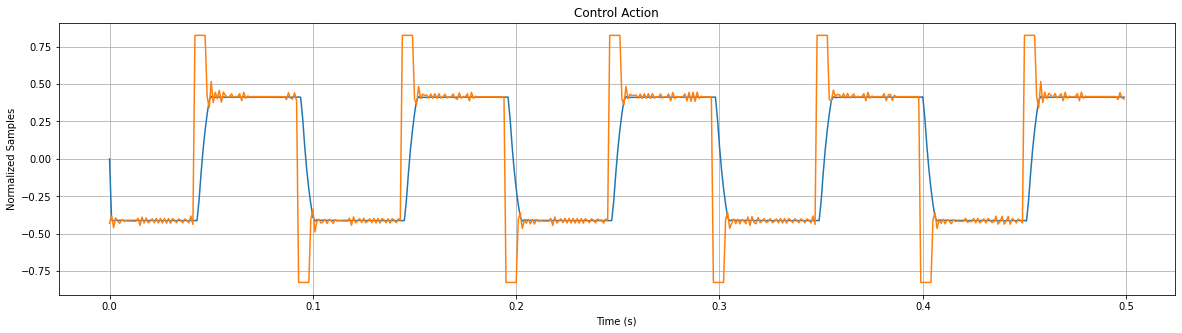

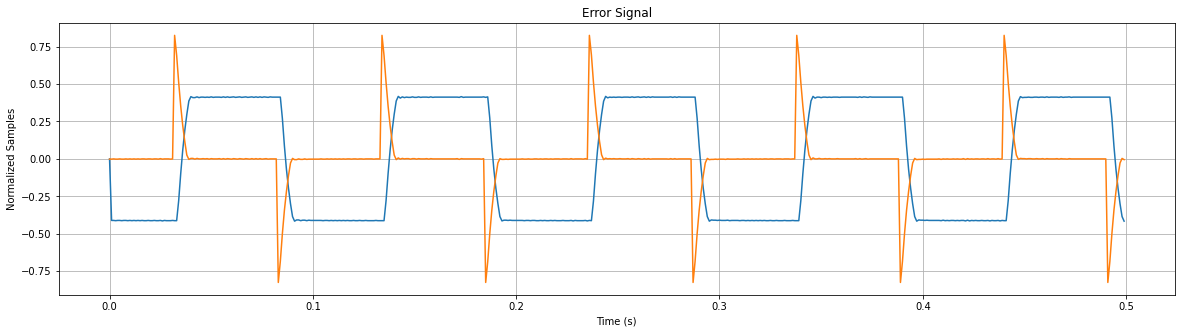

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into pandas dataframes
error_df = pd.read_csv("csvs/pid_error.csv")
ctrl_action_df = pd.read_csv("csvs/pid_control_action.csv")
pid_tuned_df = pd.read_csv("csvs/pid_output.csv")


# Plot the error signal
plt.figure(figsize=(20, 5))
plt.plot(pid_tuned_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], pid_tuned_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(pid_tuned_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], pid_tuned_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Reference Signal')
plt.title("PID Performance")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()

# Plot the control action
plt.figure(figsize=(20, 5))
plt.plot(ctrl_action_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], ctrl_action_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(ctrl_action_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], ctrl_action_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='PID Output')
plt.title("Control Action")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()

# Plot the reference signal and control action
plt.figure(figsize=(20, 5))
plt.plot(error_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], error_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(error_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], error_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Error')
plt.title("Error Signal")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()


t_r = 3.9999999999995595 ms < 9.799999999999999
Overshoot 0.78%


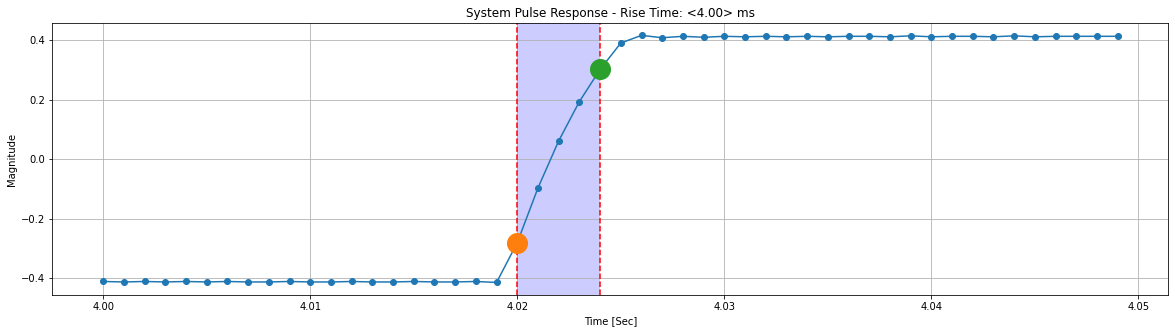

In [314]:
# Metrics
# Calculamos los límites para el risetime.
v10 = (pid_tuned_df['ADC'].max() - pid_tuned_df['ADC'].min())*.1 + pid_tuned_df['ADC'].min()
v90 = (pid_tuned_df['ADC'].max() - pid_tuned_df['ADC'].min())*.9 + pid_tuned_df['ADC'].min()

offset = 4000
data = np.array(pid_tuned_df['ADC'][offset:offset+(SR_F_HZ//SQ_WAVE_F_HZ//2)]) 
tme = np.array(pid_tuned_df['Time'][offset:offset+(SR_F_HZ//SQ_WAVE_F_HZ//2)]) 

# Cleanup missed samples
zero_indices = np.where(data == 0)[0]

# Replace zeros with previous value
for i in zero_indices:
    data[i] = data[i-1]

# Buscamos los instantes en los que ocurren.
t10_i = np.argmin(np.abs(data - v10)) 
t90_i = np.argmin(np.abs(data - v90))

# Calculamos el Risetime.
tr = abs(tme[t90_i] - tme[t10_i])
print(f't_r = {tr * 1000} ms < {14 * 0.7}')

# Graficamos.
plt.figure(figsize=(20, 5))
plt.plot(tme, data, '-o')
plt.axvline(tme[t10_i], color='red', linestyle='--')
plt.axvline(tme[t90_i], color='red', linestyle='--')
plt.axvspan(tme[t10_i], tme[t90_i], facecolor='blue', alpha=0.2)
plt.plot(tme[t10_i], data[t10_i], 'o', markersize=20)
plt.plot(tme[t90_i], data[t90_i], 'o', markersize=20)
plt.title(f'System Pulse Response - Rise Time: <{tr * 1000:.2f}> ms')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()


# Overshoot
osht = (pid_tuned_df['ADC'].max() / pid_tuned_df['DAC'].max() - 1.) * 100
print(f'Overshoot {osht:.2f}%')


| System/Controller Performance | Before Applying PID Controller | After Applying PID Controller |
|:------------------------------:|:------------------------------:|:------------------------------:|
|         Rise Time (ms)         |             12.0               |                4               |
|        Overshoot (%)          |               0                |              0.78              |


j# Pole Placement

[0.01044583+0.j 0.64503727+0.j]
[[0.37964295 0.60778899]]
1.9874319426885374


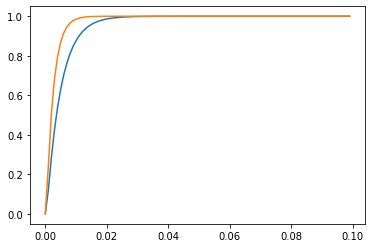

In [462]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt
import math as mt

# Define the system transfer function
R1 = 10e3
C1 = 100e-9
R2 = 10e3
C2 = 200e-9 

# R1 = 1e3
# C1 = 1e-6
# R2 = 2e3
# C2 = 1e-6

h = 1e-3
t = np.arange(0, .1, h)

# num = [1]
# den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
# sys_tf = cnt.tf(num, den)
# sys = cnt.tf2ss(sys_tf)
# sysd = cnt.c2d(sys, h)

A = [[-(1/R1+1/R2)/C1, 1/(R2*C1)], [1/(R2*C2), -1/(R2*C2)]]
B = [[1/(R1*C1)], [0]]
C = [[0, 1]]
sys = cnt.ss(A, B, C, 0)
sysd = cnt.c2d(sys, h)
sys_tf = cnt.ss2tf(sys)

def sim_ss(sys_disc, k=[[0, 0]], k0=1):
    x = np.zeros((len(sys_disc.A), len(t)+1))
    y = np.zeros((1, len(t)))
    u = np.ones((1, len(t)))

    for i in range(len(t)):
        x[:, i+1] = np.matmul(sys_disc.A, x[:, i]) - np.matmul(np.matmul(sys_disc.B, k), x[:, i])  + np.multiply(k0, np.matmul(sys_disc.B, u[:, i])) 
        y[:, i] = np.matmul(sys_disc.C, x[:,i])
    return x, y, u

def disc_dcgain(sys_disc):
  return np.matmul(np.matmul(sys_disc.C, np.linalg.inv(np.eye(2) - sys_disc.A)), sys_disc.B)[0, 0]  

x, y, u = sim_ss(sysd)
plt.plot(t, y[0])


P = cnt.pole(sys_tf)
Pd = np.exp(P*2*h)
print(Pd)
K = cnt.place(sysd.A, sysd.B, [Pd[0], Pd[1]])
print(K)
x, y, u = sim_ss(sysd, K)
# plt.plot(t, y[0])

sysdlc = cnt.ss(sysd.A - np.matmul(sysd.B, K), sysd.B, sysd.C, sysd.D)

print(1 / disc_dcgain(sysdlc))

x, y, u = sim_ss(sysd, K, 1/disc_dcgain(sysdlc))
plt.plot(t, y[0])


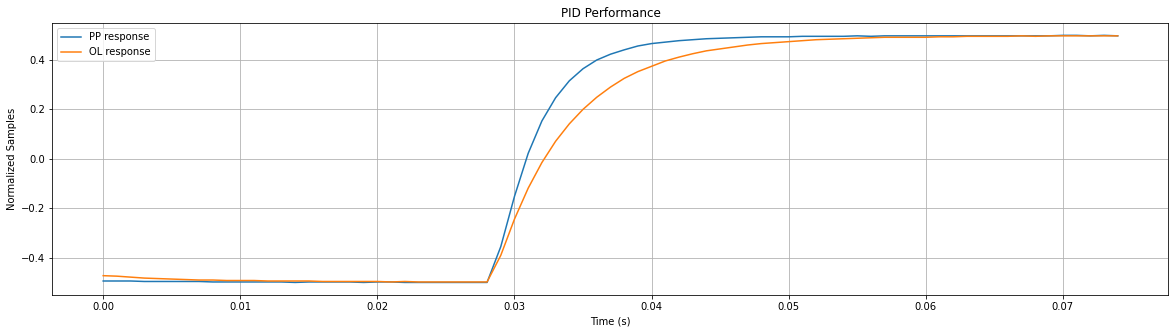

In [485]:

# Load the CSV files into pandas dataframes
pp_df = pd.read_csv("csvs/adcx2_dacx1.csv")
ol_df = pd.read_csv("csvs/step_resp.csv")

pp = extract_data(pp_df, periods=.75, samples_offset=10)
ol = extract_data(ol_df, periods=.75, samples_offset=72)

# Plot the error signal
plt.figure(figsize=(20, 5))
plt.plot(pp['Time'], pp['ADC'], label='PP response')
plt.plot(pp['Time'], ol['ADC'], label='OL response')
plt.title("PID Performance")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.legend()
plt.grid()
plt.show()

0.006999999999999996
0.012
Improvement: 41.66666666666671%


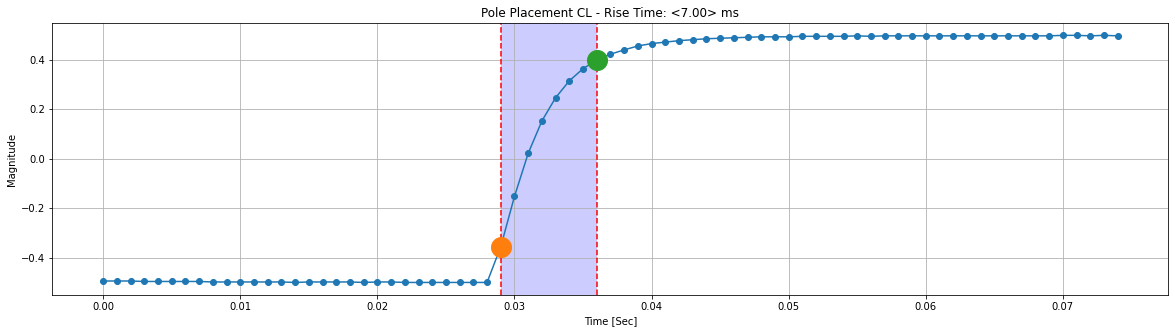

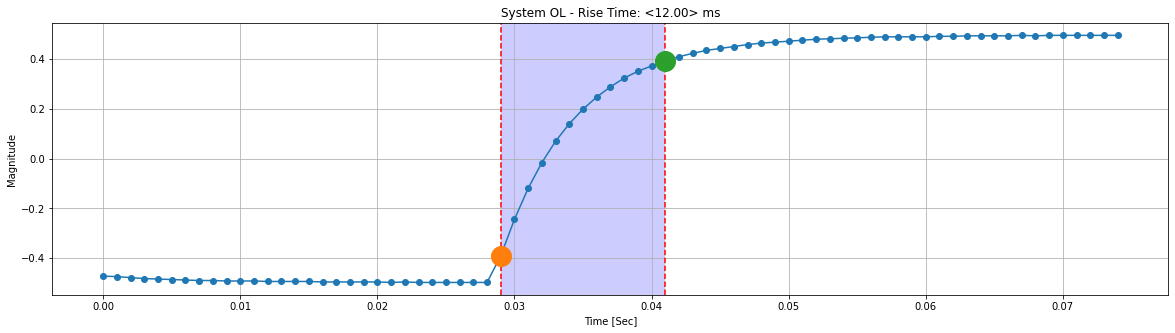

In [493]:
pptr = plot_risetime(pp, 'Pole Placement CL')
oltr = plot_risetime(ol, 'System OL')
print(f'Improvement: {(1-(pptr/oltr)) * 100}%')